# Project 2
## JPY/USD Exchange Rate Forecasting Using Time-series Data Forecasting Techniques

In [1]:
# import the packages and libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
%matplotlib inline

# Set global random seed
np.random.seed(7012)

# Set global plotting style
sns.set_style("whitegrid", {"xtick.major.size": 8, "ytick.major.size": 8, 'legend.frameon': True})
sns.set_palette("dark")

# Read and set up dataframe
data = pd.read_csv('P2training.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True, drop=True)

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data[:'1980-1-10']

,AUD/USD,GBP/USD,CAD/USD,NLG/USD,FRF/USD,DEM/USD,JPY/USD,CHF/USD
Date,,,,,,,,
1979-12-31,0.904404,0.450755,1.1684,1.9020,4.0175,1.7260,240.30,1.5950
1980-01-02,0.902527,0.445891,1.1658,1.8922,4.0150,1.7135,238.45,1.5775
1980-01-03,0.901388,0.446429,1.1703,1.8900,4.0100,1.7108,238.35,1.5720
1980-01-04,0.901713,0.447027,1.1687,1.8910,4.0250,1.7126,234.80,1.5755
1980-01-07,0.898311,0.442184,1.1694,1.8890,4.0090,1.7080,231.55,1.5700
1980-01-08,0.898876,0.442087,1.1698,1.8915,4.0125,1.7129,234.75,1.5770
1980-01-09,0.898473,0.441306,1.1686,1.8915,4.0125,1.7122,234.95,1.5740
1980-01-10,0.899281,0.442870,1.1650,1.8950,4.0230,1.7168,235.80,1.5790


In [3]:
jpy_usd = data['JPY/USD']
log_jpy_usd = np.log(jpy_usd)
jpy_usd_100 = jpy_usd.head(100)
jpy_usd_1000 = jpy_usd.head(1000)

# Exploratory Data Analysis

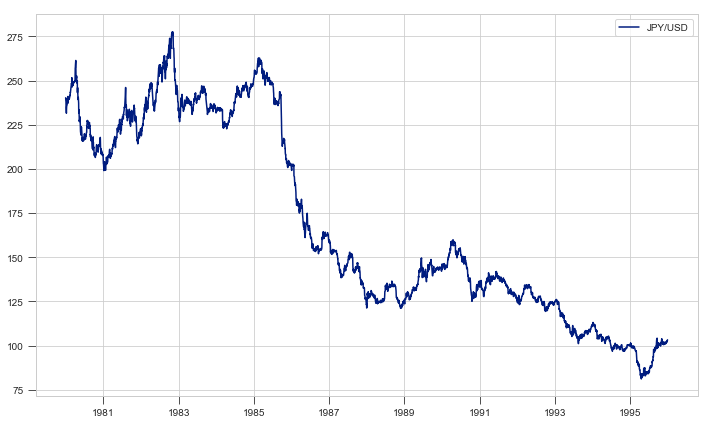

In [4]:
fig = plt.figure(figsize=(10,6))
plt.plot('JPY/USD', data=data)
plt.legend()
plt.tight_layout()

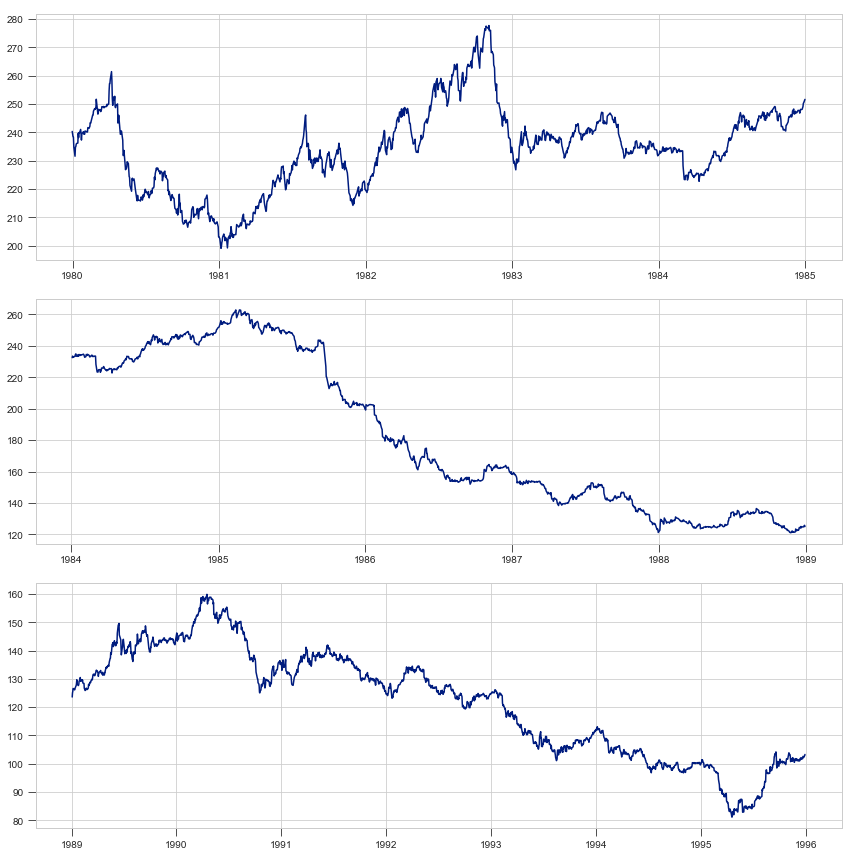

In [8]:
# Visualise data in different time periods
fig, ax = plt.subplots(3,1,figsize=(12,12))
ax[0].plot('JPY/USD', data=data[:'1984'])
ax[1].plot('JPY/USD', data=data['1984':'1988'])
ax[2].plot('JPY/USD', data=data['1989':])
plt.tight_layout()
plt.savefig('jpy_usd_three_periods.pdf')

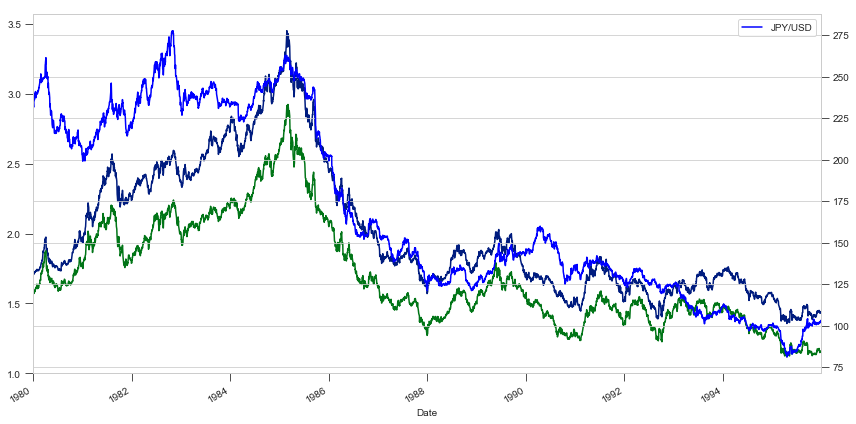

In [9]:
# Visualise data with other currencies
plt.figure(figsize=(12,6))
data['DEM/USD'].plot()
data['CHF/USD'].plot()
#data['FRF/USD'].plot()
#data['AUD/USD'].plot()
data['JPY/USD'].plot(secondary_y=True, c='b')
plt.legend(loc='best')
plt.tight_layout()

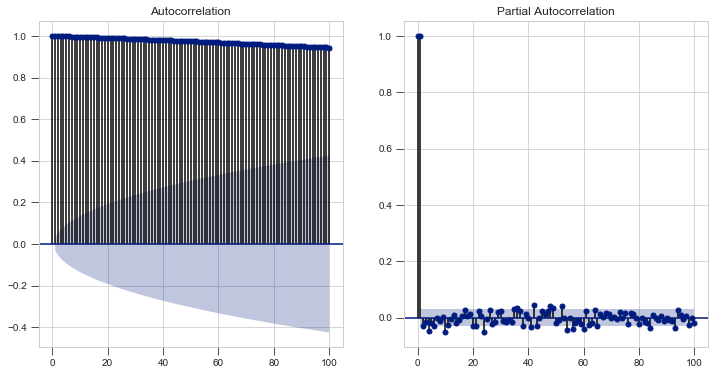

In [12]:
# SACF and SPACF
alpha=0.05
lags=100

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig = sgt.plot_acf(jpy_usd, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
fig = sgt.plot_pacf(jpy_usd, ax=ax[1], lags=lags, alpha=alpha, method='ols')
plt.savefig('sacf_n_spacf_plot.pdf')

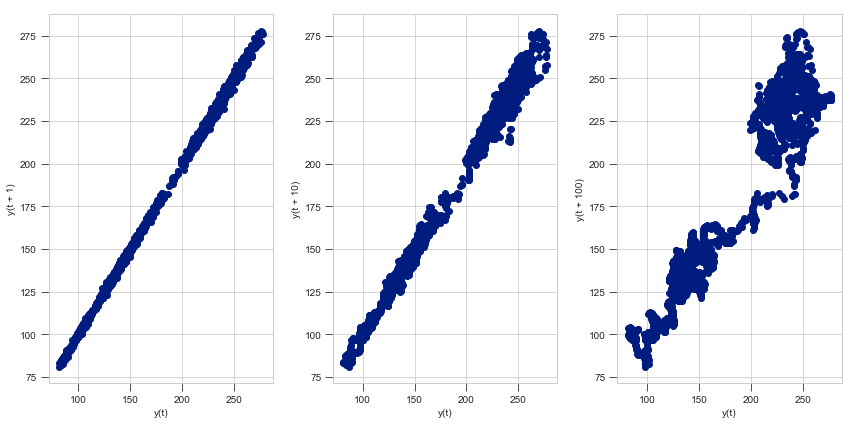

In [15]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
pd.plotting.lag_plot(jpy_usd, lag=1, ax = ax[0])
pd.plotting.lag_plot(jpy_usd, lag=10, ax = ax[1])
pd.plotting.lag_plot(jpy_usd, lag=100, ax = ax[2])
plt.tight_layout()
plt.savefig('three_lag_plots.pdf')

# Part 1

# Model Selection

## EWMA

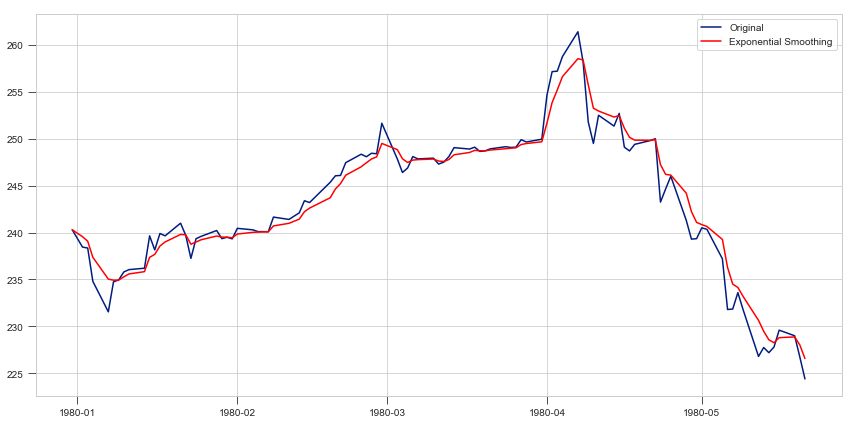

In [17]:
al = .4;
ewma = jpy_usd_100.ewm(alpha=al, min_periods=0, freq=None, adjust=False)
plt.figure(figsize=(12,6))
plt.plot(jpy_usd_100, label='Original')
plt.plot(ewma.mean(), color='red', label='Exponential Smoothing')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('test.jpeg')

1.0 1.1563402387


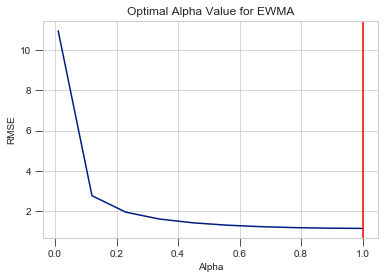

In [20]:
alpha = np.linspace(0.01,1,num=10)
err = [];
for al in alpha:
    ewma = jpy_usd.ewm(alpha=al, min_periods=0, freq=None)
    pred = ewma.mean();
    diff = jpy_usd - pred.shift(1);
    err.append(np.sqrt((diff ** 2).mean()))
    
plt.plot(alpha, err)
optal = alpha[np.argmin(err)]
plt.axvline(x=optal, color='red')
print(optal, min(err))
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Optimal Alpha Value for EWMA')
plt.savefig('optimal_alpha_ewma.pdf')

## Double Exponential Smoothing

In [23]:
# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta, L0, B0):
    result = []
    # No prediction for the first value
    result.append(np.nan)
    for n in range(0, len(series)):
        val = series[n]
        if n==0:
            level = alpha*val + (1-alpha)*(L0+B0);
            trend = beta*(level-L0) + (1-beta)*B0;
            last_level = level;
        else:
            level = alpha*val + (1-alpha)*(last_level+trend)
            trend = beta*(level-last_level) + (1-beta)*trend
            last_level = level;
            
        result.append(level+trend)
        
    # No prediction for the (n+1)th value
    return result[:-1]

SSE: 5533.046


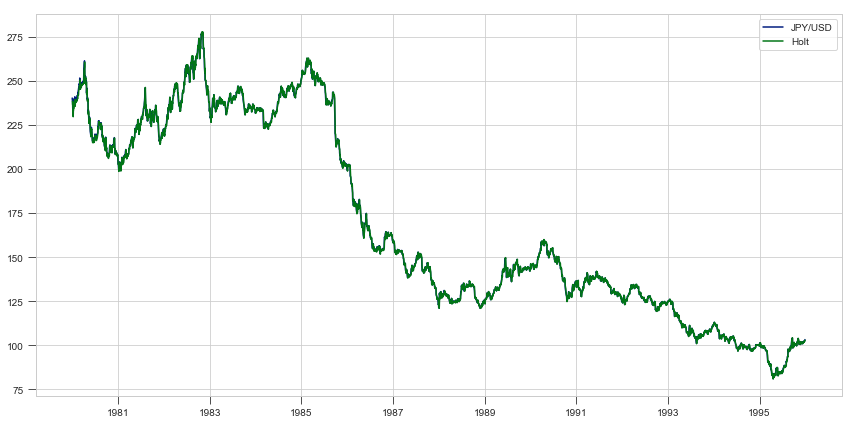

In [24]:
a = 1;
b = .01;
series = jpy_usd.values
holt = double_exponential_smoothing(series, a, b, series[0], series[1]-series[0])
holt = pd.DataFrame({"holt": holt}, index=jpy_usd.index)

SSE = np.sum(np.power(jpy_usd.values[1:] - holt.dropna().holt.values, 2))
print("SSE: %.3f" % SSE)

fig = plt.figure(figsize=(12,6))
plt.plot(jpy_usd)
plt.plot(holt, label='Holt')
plt.legend(loc='best')
plt.tight_layout()

In [25]:
alpha = np.linspace(0.01,1,num=10)
beta = np.linspace(0.01,1,num=10)

series = jpy_usd_100.values
err = [];
min_err = 10000;
for al in alpha:
    for be in beta:
        holt = double_exponential_smoothing(series, al, be, series[0], series[1]-series[0])
        holt = pd.DataFrame({"holt": holt}, index=jpy_usd_100.index)
        pred = holt.dropna().holt.values;
        diff = jpy_usd_100.values[1:] - pred;
        error = np.sqrt((diff ** 2).mean())
        if min_err > error:
            min_err = error
            alpha_hat = al
            beta_hat = be

        err.append(error)

The model seems to provide the best fit when alpha=1, which means replying completely on the last available value.

1.0 0.12


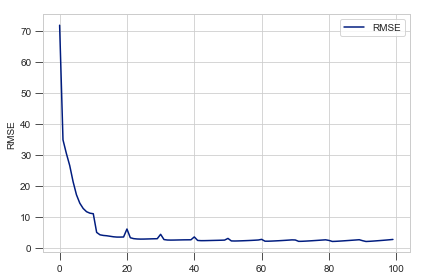

In [26]:
plt.plot(err, label='RMSE')
plt.legend()
plt.tight_layout()
print(alpha_hat, beta_hat)
plt.ylabel('RMSE')
plt.tight_layout()

 # ARMA Model

# Error Estimation

In [85]:
def cal_cv_rmse(X, orig_data, diff_order, fold, p, d, q, log):
    """Calculate root mean square 1-step-ahead forecasting error
       based on timeseries split cross validation
       
       params:
       X: data after order differencing
       orig_data: original data (could be log-transformed)
       diff_order: order of differencing in the trans_data
       fold: cross validation fold
       p, d, q: int, params for ARIMA
       log: boolean, True is X is log-transformed data
       
       return:
       RMSE: list, list of RMSE for all folds
    """
    tscv = TimeSeriesSplit(n_splits=fold)

    RMSE = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        #y_train, y_test = y[train_index], y[test_index]
        model = ARIMA(X_train, order=(p, d, q))  
        results_ns = model.fit(disp=-1) 
        
        # forcast
        forecasts = results_ns.forecast(X_test.size)[0]

        # errors 
        errors = []
        
        # get last two values from the original space
        second_last = orig_data.loc[X_train.index][-2]
        last = orig_data.loc[X_train.index][-1]
        
        if diff_order == 1:
            # first prediction
            forecasts[0] = forecasts[0] + last
            if log:
                errors.append(np.exp(forecasts[0]) - np.exp(orig_data.loc[X_test.index][0]))
            else:
                errors.append(forecasts[0] - orig_data.loc[X_test.index][0])
            
            for i in range(diff_order, X_test.size):
                # to correct for first order differencing
                forecasts[i] = forecasts[i] + orig_data.loc[X_test.index][i-1]
                if log:
                    errors.append(np.exp(forecasts[i]) - np.exp(orig_data.loc[X_test.index][i])) 
                else:
                    errors.append(forecasts[i] - orig_data.loc[X_test.index][i])

        
        if diff_order == 2:
            # first two predictions
            pred_1 = forecasts[0] + 2*last - second_last
            pred_2 = forecasts[1] + 2*pred_1 - last
            forecasts[0] = pred_1
            forecasts[1] = pred_2
            if log:
                errors.append(np.exp(pred_1) - np.exp(orig_data.loc[X_test.index][0]))
                errors.append(np.exp(pred_2) - np.exp(orig_data.loc[X_test.index][1]))
            else:
                errors.append(pred_1 - orig_data.loc[X_test.index][0])
                errors.append(pred_2 - orig_data.loc[X_test.index][1])
            for i in range(diff_order, X_test.size):
                # to correct for second order differencing
                forecasts[i] = forecasts[i] + 2*orig_data.loc[X_test.index][i-1] - orig_data.loc[X_test.index][i-2]
                if log:
                    errors.append(np.exp(forecasts[i]) - np.exp(orig_data.loc[X_test.index][i]))    
                else:
                    errors.append(forecasts[i] - orig_data.loc[X_test.index][i])    
        
        RMSE.append(np.sqrt(np.mean(np.power(errors, 2))))              
        
    return RMSE

In [86]:
data_1diff = jpy_usd - jpy_usd.shift(1)
data_1diff.dropna(inplace=True)

data_2diff = jpy_usd - 2*jpy_usd.shift(1) + jpy_usd.shift(2)
data_2diff.dropna(inplace=True)

Kfold = 10
log = False

RMSE_d_1_011 = cal_cv_rmse(data_1diff, jpy_usd, 1, Kfold, 0, 1, 1, log)
RMSE_d_2_011 = cal_cv_rmse(data_2diff, jpy_usd, 2, Kfold, 0, 1, 1, log)
RMSE_d_1_001 = cal_cv_rmse(data_1diff, jpy_usd, 1, Kfold, 0, 0, 1, log)
RMSE_d_2_001 = cal_cv_rmse(data_2diff, jpy_usd, 2, Kfold, 0, 0, 1, log)
RMSE_d_1_110 = cal_cv_rmse(data_1diff, jpy_usd, 1, Kfold, 1, 1, 0, log)
RMSE_d_2_110 = cal_cv_rmse(data_2diff, jpy_usd, 2, Kfold, 1, 1, 0, log)
RMSE_d_1_100 = cal_cv_rmse(data_1diff, jpy_usd, 1, Kfold, 1, 0, 0, log)
RMSE_d_2_100 = cal_cv_rmse(data_2diff, jpy_usd, 2, Kfold, 1, 0, 0, log)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


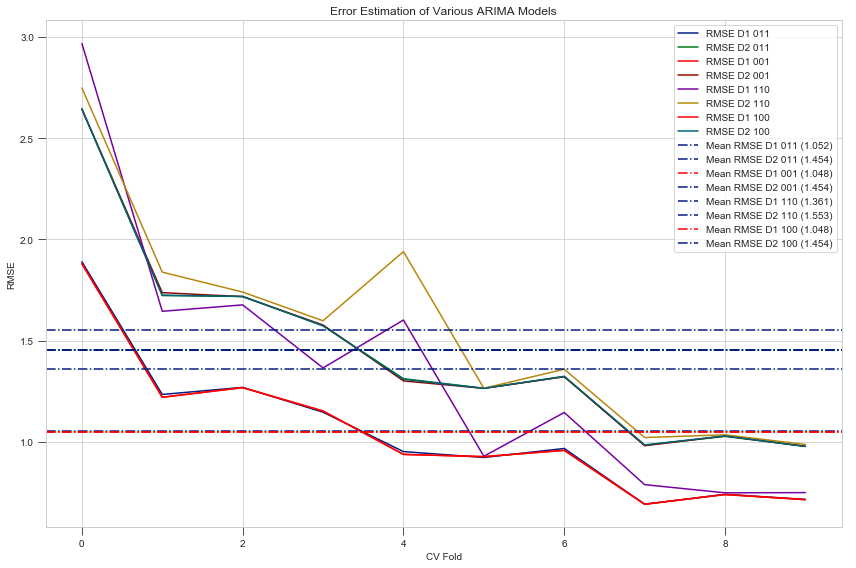

In [87]:
plt.figure(figsize=(12,8))
plt.plot(RMSE_d_1_011, label='RMSE D1 011')
plt.plot(RMSE_d_2_011, label='RMSE D2 011')
plt.plot(RMSE_d_1_001, label='RMSE D1 001', c='r')
plt.plot(RMSE_d_2_001, label='RMSE D2 001')
plt.plot(RMSE_d_1_110, label='RMSE D1 110')
plt.plot(RMSE_d_2_110, label='RMSE D2 110')
plt.plot(RMSE_d_1_100, label='RMSE D1 100', c='r')
plt.plot(RMSE_d_2_100, label='RMSE D2 100')

plt.axhline(np.mean(RMSE_d_1_011), label='Mean RMSE D1 011 (%.3f)' %np.mean(RMSE_d_1_011), linestyle='-.')
plt.axhline(np.mean(RMSE_d_2_011), label='Mean RMSE D2 011 (%.3f)' %np.mean(RMSE_d_2_011), linestyle='-.')
plt.axhline(np.mean(RMSE_d_1_001), label='Mean RMSE D1 001 (%.3f)' %np.mean(RMSE_d_1_001), c='r', linestyle='-.')
plt.axhline(np.mean(RMSE_d_2_001), label='Mean RMSE D2 001 (%.3f)' %np.mean(RMSE_d_2_001), linestyle='-.')
plt.axhline(np.mean(RMSE_d_1_110), label='Mean RMSE D1 110 (%.3f)' %np.mean(RMSE_d_1_110), linestyle='-.')
plt.axhline(np.mean(RMSE_d_2_110), label='Mean RMSE D2 110 (%.3f)' %np.mean(RMSE_d_2_110), linestyle='-.')
plt.axhline(np.mean(RMSE_d_1_100), label='Mean RMSE D1 100 (%.3f)' %np.mean(RMSE_d_1_100), c='r', linestyle='-.')
plt.axhline(np.mean(RMSE_d_2_100), label='Mean RMSE D2 100 (%.3f)' %np.mean(RMSE_d_2_100), linestyle='-.')

plt.xlabel('CV Fold')
plt.ylabel('RMSE')
plt.title('Error Estimation of Various ARIMA Models')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('error_estimation_1.pdf')

## ARMA model on log-transformed data

In [88]:
log_data_1diff = log_jpy_usd - log_jpy_usd.shift(1)
log_data_1diff.dropna(inplace=True)

log_data_2diff = log_jpy_usd - 2*log_jpy_usd.shift(1) + log_jpy_usd.shift(2)
log_data_2diff.dropna(inplace=True)

log = True

log_RMSE_d_1_011 = cal_cv_rmse(log_data_1diff, log_jpy_usd, 1, Kfold, 0, 1, 1, log)
log_RMSE_d_2_011 = cal_cv_rmse(log_data_2diff, log_jpy_usd, 2, Kfold, 0, 1, 1, log)
log_RMSE_d_1_001 = cal_cv_rmse(log_data_1diff, log_jpy_usd, 1, Kfold, 0, 0, 1, log)
log_RMSE_d_2_001 = cal_cv_rmse(log_data_2diff, log_jpy_usd, 2, Kfold, 0, 0, 1, log)
log_RMSE_d_1_110 = cal_cv_rmse(log_data_1diff, log_jpy_usd, 1, Kfold, 1, 1, 0, log)
log_RMSE_d_2_110 = cal_cv_rmse(log_data_2diff, log_jpy_usd, 2, Kfold, 1, 1, 0, log)
log_RMSE_d_1_100 = cal_cv_rmse(log_data_1diff, log_jpy_usd, 1, Kfold, 1, 0, 0, log)
log_RMSE_d_2_100 = cal_cv_rmse(log_data_2diff, log_jpy_usd, 2, Kfold, 1, 0, 0, log)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


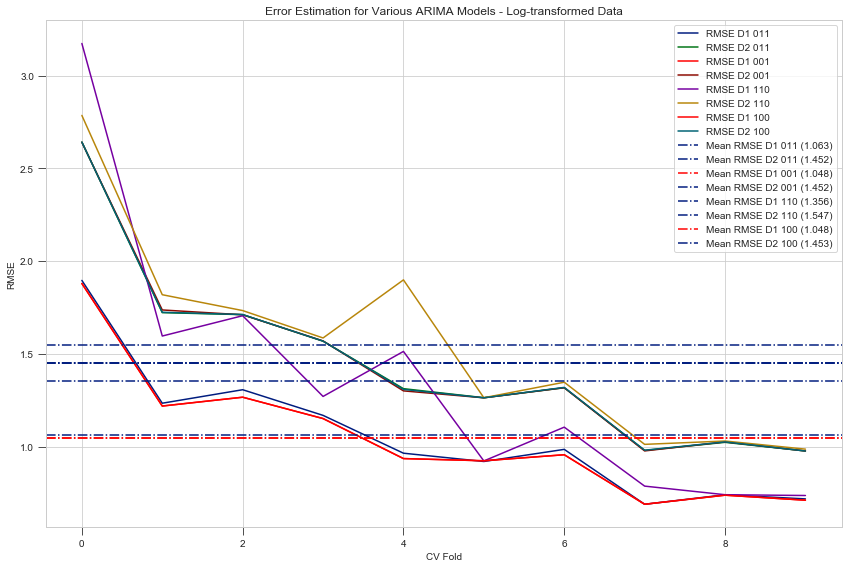

In [89]:
plt.figure(figsize=(12,8))
plt.plot(log_RMSE_d_1_011, label='RMSE D1 011')
plt.plot(log_RMSE_d_2_011, label='RMSE D2 011')
plt.plot(log_RMSE_d_1_001, label='RMSE D1 001', c='r')
plt.plot(log_RMSE_d_2_001, label='RMSE D2 001')
plt.plot(log_RMSE_d_1_110, label='RMSE D1 110')
plt.plot(log_RMSE_d_2_110, label='RMSE D2 110')
plt.plot(log_RMSE_d_1_100, label='RMSE D1 100', c='r')
plt.plot(log_RMSE_d_2_100, label='RMSE D2 100')

plt.axhline(np.mean(log_RMSE_d_1_011), label='Mean RMSE D1 011 (%.3f)' %np.mean(log_RMSE_d_1_011), linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_2_011), label='Mean RMSE D2 011 (%.3f)' %np.mean(log_RMSE_d_2_011), linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_1_001), label='Mean RMSE D1 001 (%.3f)' %np.mean(log_RMSE_d_1_001), c='r', linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_2_001), label='Mean RMSE D2 001 (%.3f)' %np.mean(log_RMSE_d_2_001), linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_1_110), label='Mean RMSE D1 110 (%.3f)' %np.mean(log_RMSE_d_1_110), linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_2_110), label='Mean RMSE D2 110 (%.3f)' %np.mean(log_RMSE_d_2_110), linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_1_100), label='Mean RMSE D1 100 (%.3f)' %np.mean(log_RMSE_d_1_100), c='r', linestyle='-.')
plt.axhline(np.mean(log_RMSE_d_2_100), label='Mean RMSE D2 100 (%.3f)' %np.mean(log_RMSE_d_2_100), linestyle='-.')

plt.xlabel('CV Fold')
plt.ylabel('RMSE')
plt.title('Error Estimation for Various ARIMA Models - Log-transformed Data')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('error_estimation_2.pdf')

# ARMA Model on 1st Order Differencing Log-transformed Data

## Since both original data and log data shows D1 001 model has the lowest average cross-validated forecasting error, ARIMA(0,0,1) on 1st order differencing data is selected as the best model

## Observed non-stationarity: 
Change of means in the years before 1986 and the years after 1987

Change of variance from larger variance before 1986 to smaller variance after 1987

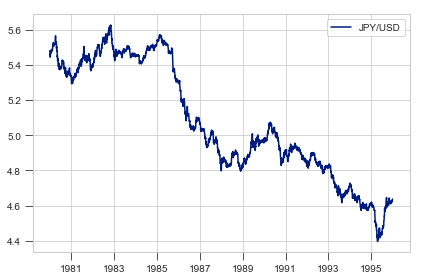

In [34]:
# Data after 1st order differencing
plt.plot(log_jpy_usd)
plt.legend()
plt.tight_layout()

In [35]:
log_data_1diff = log_jpy_usd - log_jpy_usd.shift(1)
log_data_1diff.dropna(inplace=True)

log_data_2diff = log_jpy_usd - 2*log_jpy_usd.shift(1) + log_jpy_usd.shift(2)
log_data_2diff.dropna(inplace=True)

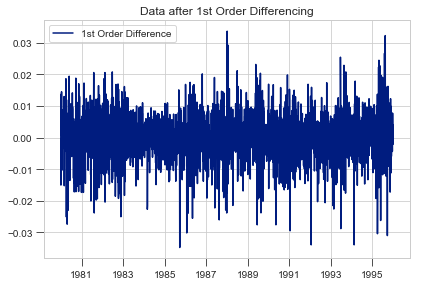

In [42]:
# Visualise data after differencing
# fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.plot(log_data_1diff, label='1st Order Difference')
plt.legend()
# ax[1].plot(log_data_2diff, label='2nd Order')
# ax[1].legend()
plt.tight_layout()
plt.title('Data after 1st Order Differencing')
plt.savefig('data_1_d_diff.pdf')

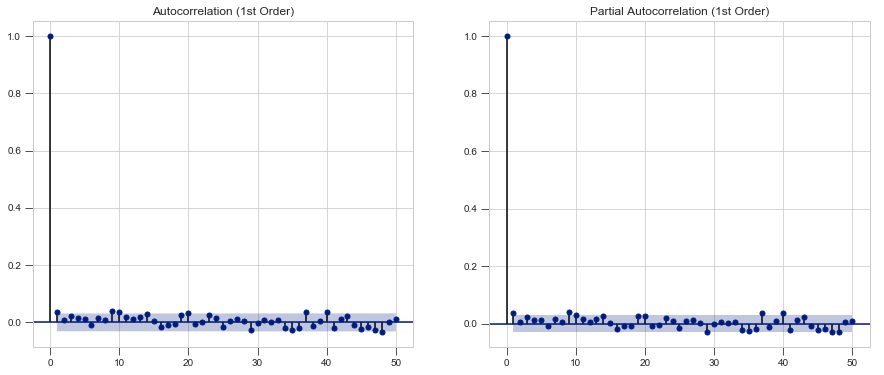

In [63]:
# SACF and SPACF
alpha=0.05
lags=50

fig, ax = plt.subplots(1,2,figsize=(15,6))
fig = sgt.plot_acf(log_data_1diff, ax=ax[0], lags=lags, alpha=alpha, unbiased=True, 
                   title='Autocorrelation (1st Order)')
fig = sgt.plot_pacf(log_data_1diff, ax=ax[1], lags=lags, alpha=alpha, method='ols', 
                    title='Partial Autocorrelation (1st Order)')

In [64]:
from statsmodels.tsa.arima_model import ARIMA

data_to_fit = log_data_1diff

model = ARIMA(data_to_fit, order=(0, 0, 1))  
results_ns = model.fit(disp=-1) 
print(results_ns.summary())

                              ARMA Model Results                              
Dep. Variable:                JPY/USD   No. Observations:                 4018
Model:                     ARMA(0, 1)   Log Likelihood               14459.548
Method:                       css-mle   S.D. of innovations              0.007
Date:                Sun, 19 Nov 2017   AIC                         -28913.096
Time:                        20:34:41   BIC                         -28894.200
Sample:                    01-02-1980   HQIC                        -28906.400
                         - 12-29-1995                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -1.943      0.052      -0.000    1.84e-06
ma.L1.JPY/USD     0.0359      0.016      2.284      0.022       0.005       0.067
                                    Root

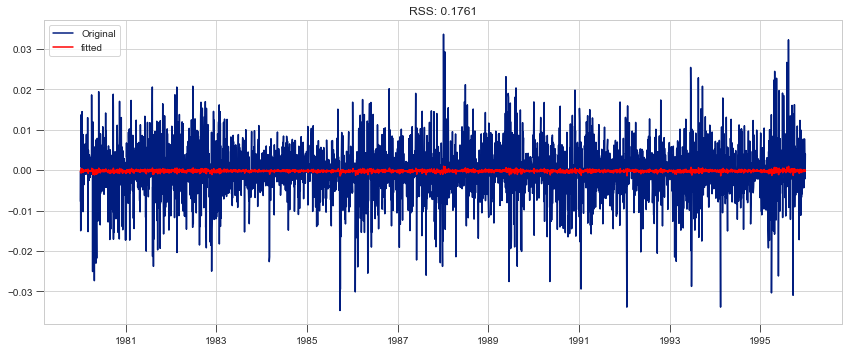

In [65]:
fig = plt.figure(figsize=(12,5))
plt.plot(data_to_fit, label='Original')
plt.plot(results_ns.fittedvalues, color='red', label='fitted')
plt.legend(loc='best')
plt.title('RSS: %.4f'% sum((results_ns.fittedvalues-data_to_fit[:])**2))
plt.tight_layout()

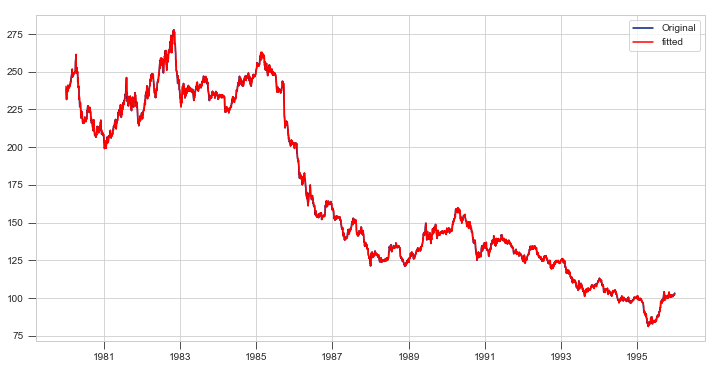

In [66]:
# map the prediction in the original space
pred = log_jpy_usd.copy();
pred.loc[data_to_fit.index] = results_ns.fittedvalues
# the first few samples are used as initial values
allday = pred.index;
for day in data_to_fit.index:
    # get the index of the day
    idx = allday.get_loc(day);
    pred.iloc[idx] = pred.iloc[idx] + jpy_usd.iloc[idx-1];
    #pred.iloc[idx] = pred.iloc[idx] + 2*jpy_usd.iloc[idx-1] - jpy_usd.iloc[idx-2];
    
fig = plt.figure(figsize=(12,6))
plt.plot(jpy_usd[1:], label='Original')
plt.plot(pred[1:], color='red', label='fitted')
plt.legend(loc='best')

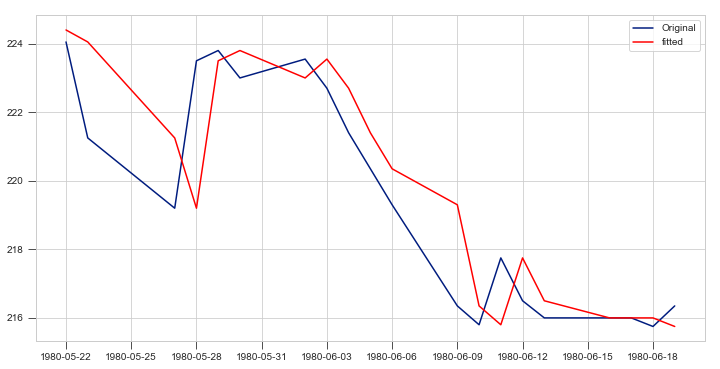

In [67]:
fig = plt.figure(figsize=(12,6))
plt.plot(jpy_usd[100:120], label='Original')
plt.plot(pred[100:120], color='red', label='fitted')
plt.legend(loc='best')

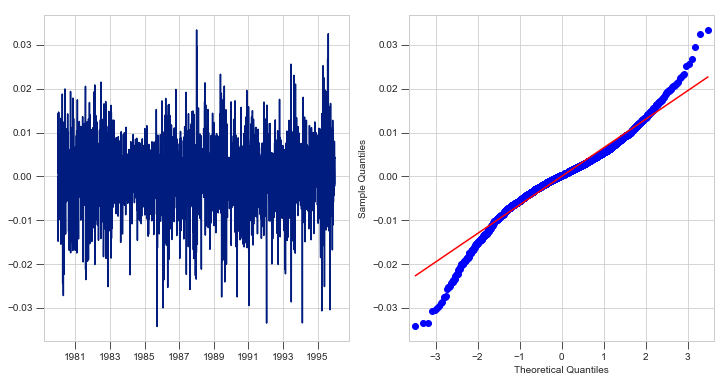

In [68]:
import scipy.stats as stats
res = results_ns.resid
#res = res[13:,]

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(res)
fig = sm.qqplot(res, stats.distributions.norm, line='r', ax=ax[1]) 
plt.savefig('res_after_arma.pdf')

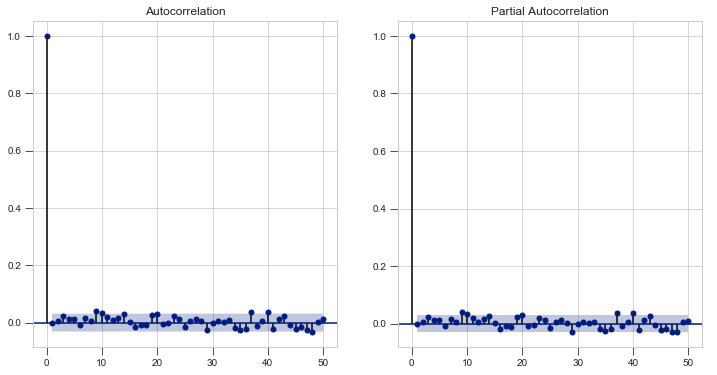

In [69]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
fig = sgt.plot_acf(res, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
fig = sgt.plot_pacf(res, ax=ax[1], lags=lags, alpha=alpha, method='ols')
plt.savefig('sacf_n_spacf_after_arma.pdf')

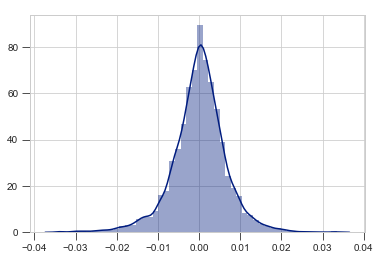

In [44]:
hist = sns.distplot(results_ns.resid)

In [45]:
RMSE = cal_cv_rmse(log_data_1diff, log_jpy_usd, 1, Kfold, 0, 0, 1, True)

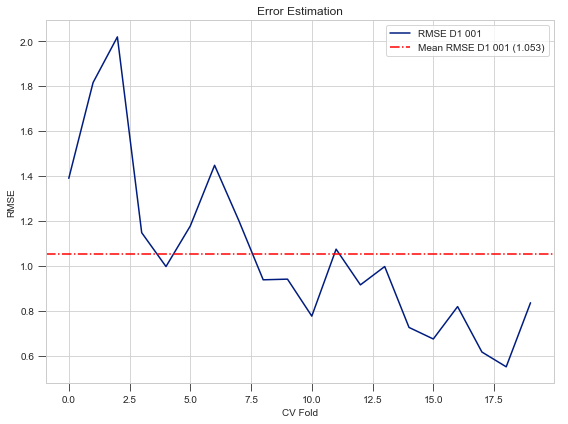

In [46]:
plt.figure(figsize=(8,6))
plt.plot(RMSE, label='RMSE D1 001')
plt.axhline(np.mean(RMSE), label='Mean RMSE D1 001 (%.3f)' %np.mean(RMSE), c='r', linestyle='-.')
plt.xlabel('CV Fold')
plt.ylabel('RMSE')
plt.title('Error Estimation')
plt.legend(loc='best')
plt.tight_layout()

## Regression on Time

In [70]:
data = pd.read_csv('P2training.csv')
data['Date'] = pd.to_datetime(data['Date'])

df = pd.DataFrame(data[['Date']])
df['JPY_USD'] = data['JPY/USD']
#df['JPY_USD'] = np.log(data['JPY/USD'])

In [71]:
month = []
year = []
day = []
dow = []
for item in df['Date']:
    month.append(item.month)
    year.append(item.year)
    day.append(item.day)
    dow.append(item.dayofweek+1)

In [72]:
df['Year'] = year
df['Month'] = month
df['Day'] = day
df['DoW'] = dow
df['bef_1986'] = (df['Year'] < 1986)
df['jpy_usd_lag_1'] = df['JPY_USD'].shift(1)
df['jpy_usd_lag_5'] = df['JPY_USD'].shift(5)
df['jpy_usd_lag_10'] = df['JPY_USD'].shift(10)
df['diff_lag_1_lag_2'] = df['JPY_USD'].shift(1) - df['JPY_USD'].shift(2)

df.head()

,Date,JPY_USD,Year,Month,Day,DoW,bef_1986,jpy_usd_lag_1,jpy_usd_lag_5,jpy_usd_lag_10,diff_lag_1_lag_2
0,1979-12-31,240.30,1979,12,31,1,True,NaN,NaN,NaN,NaN
1,1980-01-02,238.45,1980,1,2,3,True,240.30,NaN,NaN,NaN
2,1980-01-03,238.35,1980,1,3,4,True,238.45,NaN,NaN,-1.85
3,1980-01-04,234.80,1980,1,4,5,True,238.35,NaN,NaN,-0.10
4,1980-01-07,231.55,1980,1,7,1,True,234.80,NaN,NaN,-3.55


## Compare performance of difference regression models

In [73]:
def cal_cv_rmse_reg(X, formula, fold):
    """Calculate root mean square forecasting error
       based on timeseries split cross validation, regression model
       on data is used.
       
       params:
       X: dataframe, data for fitting
       formula: string, formula for ols regression
       fold: int, cross validation fold
       
       return:
       RMSE: list, list of RMSE for all folds
    """ 
    
    RMSE = []
    tscv = TimeSeriesSplit(n_splits=fold)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]

        lmfit = smf.ols(formula, data = X_train).fit()
        
        forecasts = lmfit.predict(X_test.drop('JPY_USD', 1))
        errors = forecasts - X_test['JPY_USD']
        RMSE.append(np.sqrt(np.mean(np.power(errors, 2))))
        
    return RMSE 

In [74]:
X = df
formula1 = 'JPY_USD~C(Month)+Year+C(Day)+C(bef_1986)'
formula_lag_1 = 'JPY_USD~C(Month)+Year+C(Day)+jpy_usd_lag_1+C(bef_1986)'
formula_lag_5 = 'JPY_USD~C(Month)+Year+C(Day)+jpy_usd_lag_5+C(bef_1986)'
formula_lag_10 = 'JPY_USD~C(Month)+Year+C(Day)+jpy_usd_lag_10+C(bef_1986)'
formula_w_lag_diff = 'JPY_USD~C(Month)+Year+C(Day)+C(bef_1986)+diff_lag_1_lag_2+jpy_usd_lag_1'
formula_lag_n_cat = 'JPY_USD~C(bef_1986)+diff_lag_1_lag_2+jpy_usd_lag_1'

RMSE_wo_lag = cal_cv_rmse_reg(X, formula1, Kfold)
RMSE_w_lag_1 = cal_cv_rmse_reg(X, formula_lag_1, Kfold)
RMSE_w_lag_5 = cal_cv_rmse_reg(X, formula_lag_5, Kfold)
RMSE_w_lag_10 = cal_cv_rmse_reg(X, formula_lag_10, Kfold)
RMSE_w_lag_diff = cal_cv_rmse_reg(X, formula_w_lag_diff, Kfold)
RMSE_lag_n_cat = cal_cv_rmse_reg(X, formula_lag_n_cat, Kfold)

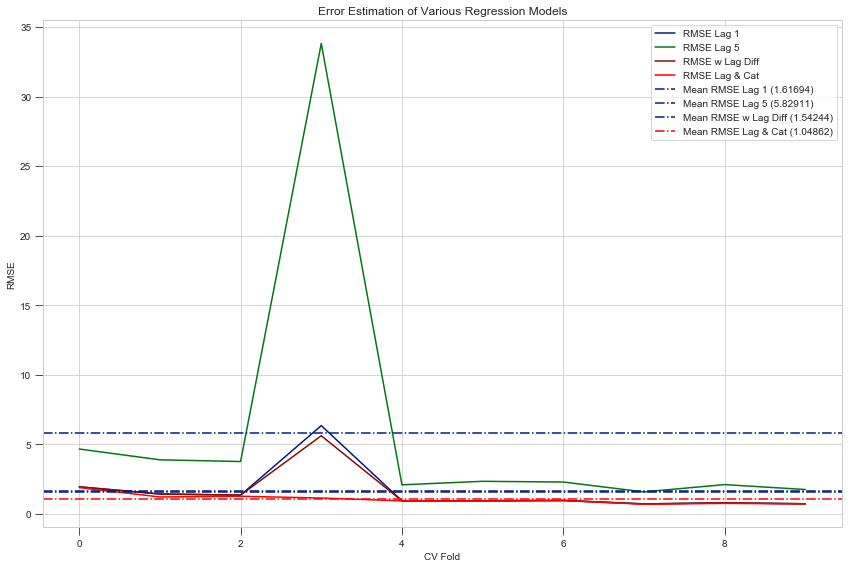

In [90]:
plt.figure(figsize=(12,8))
# plt.plot(RMSE_wo_lag, label='RMSE w/o Lag')
plt.plot(RMSE_w_lag_1, label='RMSE Lag 1')
plt.plot(RMSE_w_lag_5, label='RMSE Lag 5')
# plt.plot(RMSE_w_lag_10, label='RMSE Lag 10')
plt.plot(RMSE_w_lag_diff, label='RMSE w Lag Diff')
plt.plot(RMSE_lag_n_cat, label='RMSE Lag & Cat', c='r')


# plt.axhline(np.mean(RMSE_wo_lag), label='Mean RMSE w/o Lag (%.5f)' %np.mean(RMSE_wo_lag), linestyle='-.')
plt.axhline(np.mean(RMSE_w_lag_1), label='Mean RMSE Lag 1 (%.5f)' %np.mean(RMSE_w_lag_1), linestyle='-.')
plt.axhline(np.mean(RMSE_w_lag_5), label='Mean RMSE Lag 5 (%.5f)' %np.mean(RMSE_w_lag_5), linestyle='-.')
# plt.axhline(np.mean(RMSE_w_lag_10), label='Mean RMSE Lag 10 (%.5f)' %np.mean(RMSE_w_lag_10), linestyle='-.')
plt.axhline(np.mean(RMSE_w_lag_diff), label='Mean RMSE w Lag Diff (%.5f)' %np.mean(RMSE_w_lag_diff), linestyle='-.')
plt.axhline(np.mean(RMSE_lag_n_cat), label='Mean RMSE Lag & Cat (%.5f)' %np.mean(RMSE_lag_n_cat), linestyle='-.', c='r')


plt.legend(loc='best')
plt.title('Error Estimation of Various Regression Models')
plt.xlabel('CV Fold')
plt.ylabel('RMSE')
plt.tight_layout()
plt.savefig('error_estimation_3.pdf')

## Regression on time model is not adequate enough to predict the time series, based on the 10-fold rmse, which is much higher than that of the MA(1) model on first order differenced data. Also, the error is heavily pulled up by the period where the exchange rate declined drastically during 1986. Excluding the error of that test, the average RMSE of the rest is around 24, which is still one-fold higher than the previous model.

## However, with lagged data added to the predictors, the performance of the model improves tremendously. 

# Result: Using single currency information, regression on lag_1, lag2-lag1 and indicator variable performs the best, although considering uncertainties, they could be considered the same, for 10-fold cross validation in terms of rmse of 1-step-ahead forecasting. 

In [55]:
# Regression using the best model found in the previous section
lmfit = smf.ols(formula_lag_n_cat, data = df).fit()
lmfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                JPY_USD   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.032e+06
Date:                Sun, 19 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:32:05   Log-Likelihood:                -6274.6
No. Observations:                4017   AIC:                         1.256e+04
Df Residuals:                    4013   BIC:                         1.258e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3044      0.119      2.551      0.011       0.070       0.538
C(bef_1986)[T.True]     0.2920      0.103      2.840      0.005       0.090       0.494
diff_lag_1_lag_2        0.0316      0.016      2.004      0.045       0.001       0.062
jpy_usd_lag_1           0.9974      0.001   1101.504      0.000       0.996       0.999
==============================================================================
Omnibus:                      570.043   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3070.672
Skew:                          -0.563   Prob(JB):                         0.00
Kurtosis:                       7.132   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

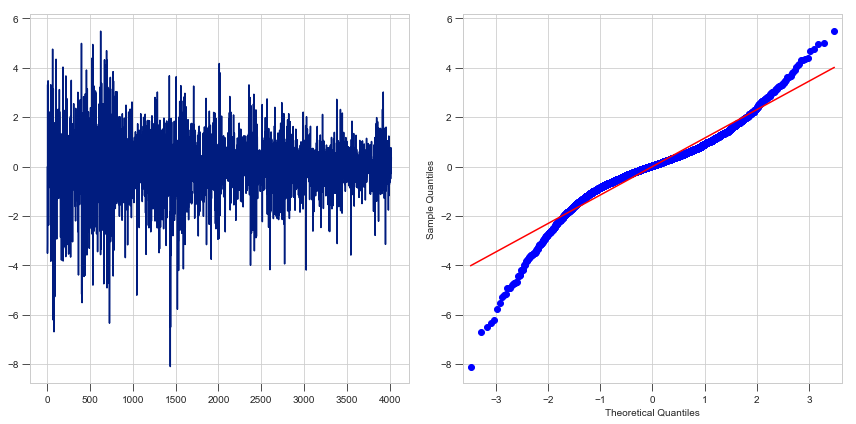

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = ax[0].plot(lmfit.resid)
fig = sm.qqplot(lmfit.resid, line='s', ax=ax[1])
plt.tight_layout()

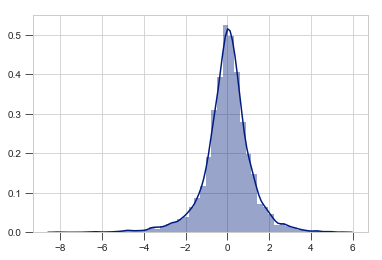

In [57]:
fit = sns.distplot(lmfit.resid)

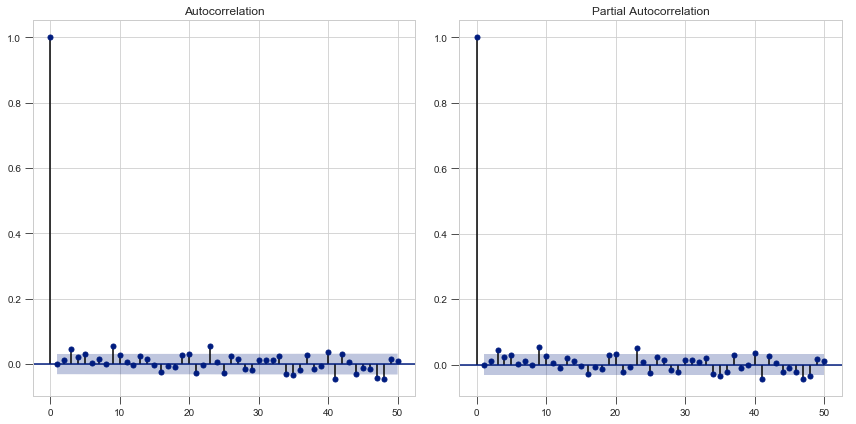

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
fig = sgt.plot_acf(lmfit.resid, lags=50, ax=ax[0])
fig = sgt.plot_pacf(lmfit.resid, lags=50, ax=ax[1])
plt.tight_layout()

# Part 2

In [59]:
newcol = []
for item in data.columns:
    newcol.append(item.replace('/', '_'))
data.columns = newcol

In [60]:
collist = list(data.columns);
collist.remove('Date')
collist.remove('JPY_USD')

In [61]:
df = data[collist].shift(1) - data[collist].shift(2)
df.head()

,AUD_USD,GBP_USD,CAD_USD,NLG_USD,FRF_USD,DEM_USD,CHF_USD
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.001877,-0.004864,-0.0026,-0.0098,-0.0025,-0.0125,-0.0175
3,-0.001139,0.000537,0.0045,-0.0022,-0.0050,-0.0027,-0.0055
4,0.000325,0.000599,-0.0016,0.0010,0.0150,0.0018,0.0035


In [62]:
df = df.merge(data, how='left')

In [63]:
df['JPY_USD'] = data['JPY_USD']
df['Date'] = data['Date']

In [64]:
month = []
year = []
day = []
dow = []
for item in data['Date']:
    month.append(item.month)
    year.append(item.year)
    day.append(item.day)
    dow.append(item.dayofweek+1)

In [65]:
#df = data.copy()
df['Year'] = year
df['Month'] = month
df['Day'] = day
df['DoW'] = dow
df['bef_1986'] = (df['Year'] < 1986)
df['jpy_usd_lag_1'] = df['JPY_USD'].shift(1)
df['diff_lag_1_lag_2'] = df['JPY_USD'].shift(1) - df['JPY_USD'].shift(2)

df.head()

,AUD_USD,GBP_USD,CAD_USD,NLG_USD,FRF_USD,DEM_USD,CHF_USD,Date,JPY_USD,Year,Month,Day,DoW,bef_1986,jpy_usd_lag_1,diff_lag_1_lag_2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979-12-31,240.30,1979,12,31,1,True,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-02,238.45,1980,1,2,3,True,240.30,NaN
2,-0.001877,-0.004864,-0.0026,-0.0098,-0.0025,-0.0125,-0.0175,1980-01-03,238.35,1980,1,3,4,True,238.45,-1.85
3,-0.001139,0.000537,0.0045,-0.0022,-0.0050,-0.0027,-0.0055,1980-01-04,234.80,1980,1,4,5,True,238.35,-0.10
4,0.000325,0.000599,-0.0016,0.0010,0.0150,0.0018,0.0035,1980-01-07,231.55,1980,1,7,1,True,234.80,-3.55


In [66]:
collist = list(df.columns);
collist.remove('Date')
collist.remove('JPY_USD')
form = 'JPY_USD' + '~' + '+'.join(collist);

In [67]:
form

'JPY_USD~AUD_USD+GBP_USD+CAD_USD+NLG_USD+FRF_USD+DEM_USD+CHF_USD+Year+Month+Day+DoW+bef_1986+jpy_usd_lag_1+diff_lag_1_lag_2'

In [68]:
form = 'JPY_USD~AUD_USD+GBP_USD+CAD_USD+NLG_USD+FRF_USD+DEM_USD+CHF_USD+C(bef_1986)+jpy_usd_lag_1'
RMSE = cal_cv_rmse_reg(df, form, Kfold)

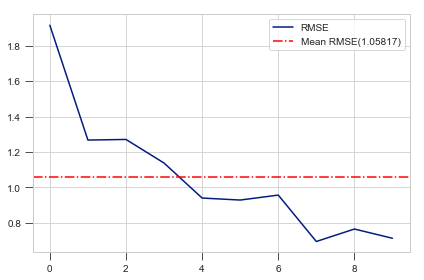

In [70]:
#plt.figure(figsize=(6,5))
plt.plot(RMSE, label='RMSE')
plt.axhline(np.mean(RMSE), label='Mean RMSE(%.5f)' %np.mean(RMSE), linestyle='-.', c='r')
plt.legend(loc='best')
plt.tight_layout()

## Correlation betwwen currencies

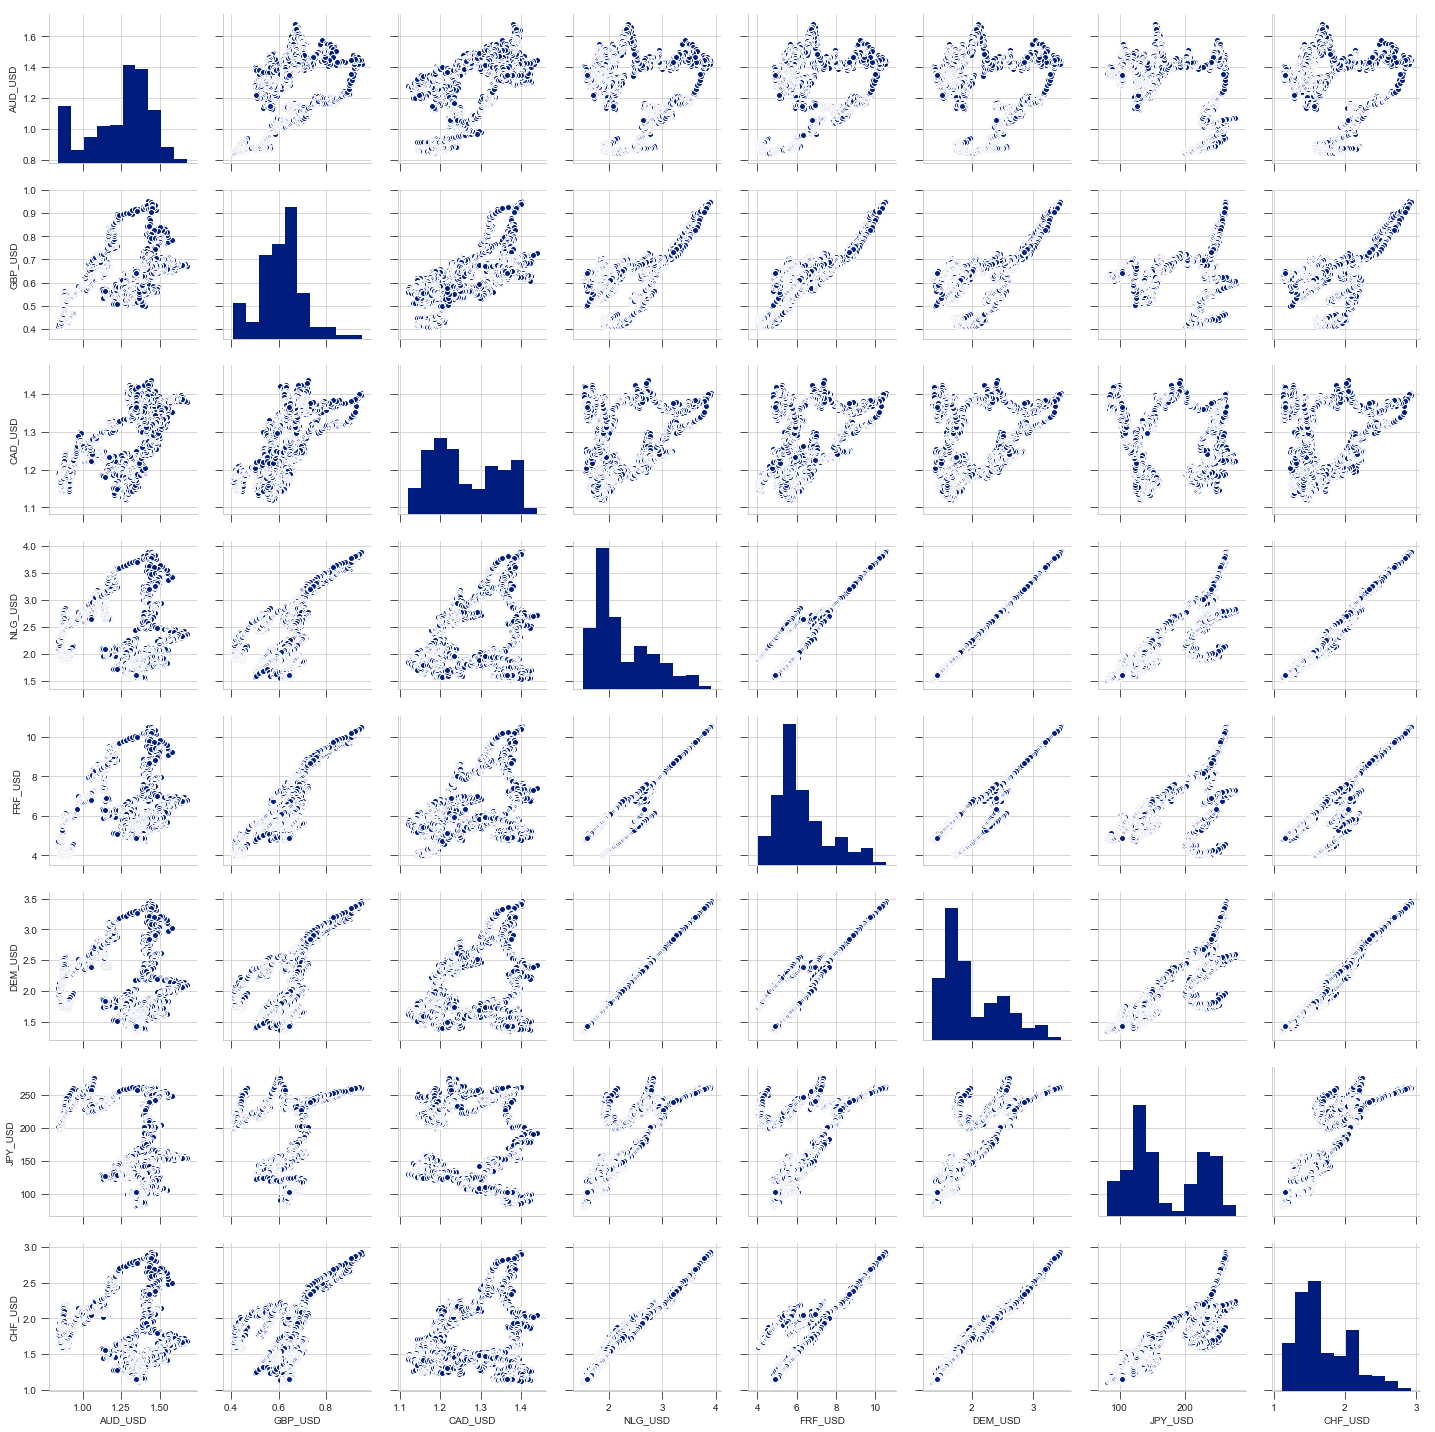

In [3474]:
sns.pairplot(data)

🐶🐹🦊🐻🐰🐭🐹🐰🦊🦊🐹🐭🐰🐰